#Imports and Dataset loading & Transformations

In [1]:
# Cell 1: Configuration, Imports & Seed Setup
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configuration and seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [2]:
# Cell 2: Data Transformations and Dataset Downloads
# STL-10 (Source Dataset)
trans_stl_train = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
trans_stl_val = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset_stl_train = datasets.STL10(root='.', split='train', download=True, transform=trans_stl_train)
dataset_stl_val   = datasets.STL10(root='.', split='test', download=True, transform=trans_stl_val)

# MNIST (Target Dataset); convert grayscale to 3 channels and resize for compatibility
trans_mnist_train = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
trans_mnist_test = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset_mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=trans_mnist_train)
dataset_mnist_test  = datasets.MNIST(root='.', train=False, download=True, transform=trans_mnist_test)

BATCH_SIZE = 64
loader_stl_train = DataLoader(dataset_stl_train, batch_size=BATCH_SIZE, shuffle=True)
loader_stl_val   = DataLoader(dataset_stl_val, batch_size=BATCH_SIZE, shuffle=False)
loader_mnist_train = DataLoader(dataset_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
loader_mnist_test  = DataLoader(dataset_mnist_test, batch_size=BATCH_SIZE, shuffle=False)

# Quick data shape check
stl_example, _ = next(iter(loader_stl_train))
mnist_example, _ = next(iter(loader_mnist_train))
print("STL-10 Images:", stl_example.size())
print("MNIST Images:", mnist_example.size())

100%|██████████| 2.64G/2.64G [09:48<00:00, 4.49MB/s]


Extracting ./stl10_binary.tar.gz to .
Files already downloaded and verified
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 247kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.49MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

STL-10 Images: torch.Size([64, 3, 96, 96])
MNIST Images: torch.Size([64, 3, 96, 96])


#Model Architecture & Pre-training on STL-10

In [3]:
# Cell 3: Model Definition
class ConvFeatureNet(nn.Module):
    def __init__(self, out_classes=10):
        super(ConvFeatureNet, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        # Classification head
        self.fc = nn.Linear(256 * 6 * 6, out_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))  # 96 -> 48
        x = self.maxpool(F.relu(self.conv2(x)))  # 48 -> 24
        x = self.maxpool(F.relu(self.conv3(x)))  # 24 -> 12
        x = self.maxpool(F.relu(self.conv4(x)))  # 12 -> 6
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Instantiate the model and print summary
net = ConvFeatureNet(out_classes=10).to(device)
print(net)

ConvFeatureNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=9216, out_features=10, bias=True)
)


In [4]:
# Cell 4: Utility Functions for Training and Evaluation
def run_epoch(model, data_loader, criterion, optimizer=None):
    is_train = optimizer is not None
    total_loss, total_correct, count = 0.0, 0, 0
    model.train() if is_train else model.eval()

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        if is_train:
            optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if is_train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_correct += (predicted == targets).sum().item()
        count += targets.size(0)
    return total_loss / count, total_correct / count

def evaluate_model(model, data_loader):
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_true.extend(targets.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
    return np.array(all_true), np.array(all_pred)

Starting Pre-training on STL-10...
Epoch 1/20 | Train: 1.8370/0.3164 | Val: 1.5529/0.4121
Epoch 2/20 | Train: 1.4689/0.4504 | Val: 1.3716/0.4805
Epoch 3/20 | Train: 1.3183/0.5168 | Val: 1.3165/0.5082
Epoch 4/20 | Train: 1.1537/0.5798 | Val: 1.2010/0.5627
Epoch 5/20 | Train: 1.0378/0.6256 | Val: 1.1522/0.5869
Epoch 6/20 | Train: 0.9064/0.6722 | Val: 1.1037/0.6094
Epoch 7/20 | Train: 0.8181/0.7068 | Val: 1.0531/0.6411
Epoch 8/20 | Train: 0.7459/0.7282 | Val: 1.1104/0.6096
Epoch 9/20 | Train: 0.6456/0.7718 | Val: 1.0879/0.6341
Epoch 10/20 | Train: 0.5368/0.8136 | Val: 1.1654/0.6304
Epoch 11/20 | Train: 0.3541/0.8884 | Val: 1.1096/0.6680
Epoch 12/20 | Train: 0.3065/0.9016 | Val: 1.1492/0.6661
Epoch 13/20 | Train: 0.2751/0.9150 | Val: 1.1588/0.6724
Epoch 14/20 | Train: 0.2608/0.9194 | Val: 1.1747/0.6721
Epoch 15/20 | Train: 0.2471/0.9228 | Val: 1.2065/0.6684
Epoch 16/20 | Train: 0.2203/0.9324 | Val: 1.2384/0.6724
Epoch 17/20 | Train: 0.2057/0.9428 | Val: 1.2572/0.6666
Epoch 18/20 | Train: 0

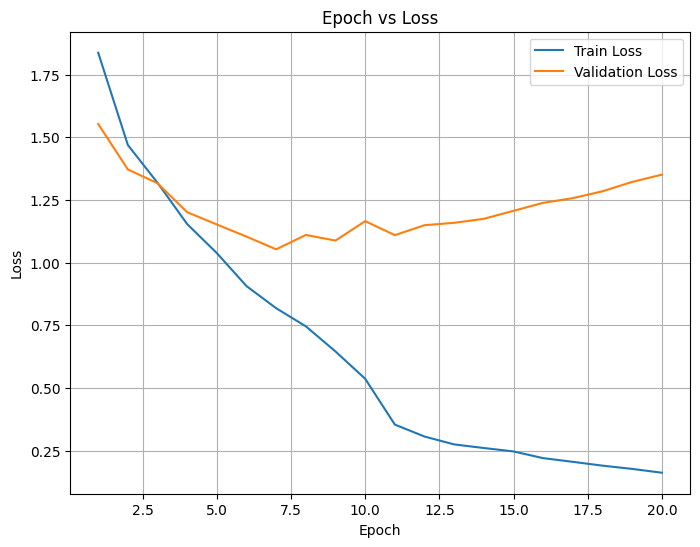

In [5]:
# Cell 5: Pre-training on STL-10
pretrain_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer_pre = Adam(net.parameters(), lr=0.001)
lr_sched = StepLR(optimizer_pre, step_size=10, gamma=0.1)

stl_train_losses, stl_val_losses = [], []
stl_train_accs, stl_val_accs = [], []

print("Starting Pre-training on STL-10...")
for ep in range(pretrain_epochs):
    train_loss, train_acc = run_epoch(net, loader_stl_train, criterion, optimizer_pre)
    val_loss, val_acc = run_epoch(net, loader_stl_val, criterion)
    stl_train_losses.append(train_loss)
    stl_val_losses.append(val_loss)
    stl_train_accs.append(train_acc)
    stl_val_accs.append(val_acc)
    lr_sched.step()
    print(f"Epoch {ep+1}/{pretrain_epochs} | Train: {train_loss:.4f}/{train_acc:.4f} | Val: {val_loss:.4f}/{val_acc:.4f}")

# Save pretrained weights to file
torch.save(net.state_dict(), "pretrained_stl10_alternative.pth")

# Plotting the training and validation loss
import matplotlib.pyplot as plt

epochs = range(1, pretrain_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, stl_train_losses, label="Train Loss")
plt.plot(epochs, stl_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()


#Transfer Learning on MNIST

In [6]:
# Cell 6: Transfer Learning Functions & Strategies
# Strategy 1: Linear Evaluation - Freeze feature extractor layers
def strategy_linear(model):
    model.load_state_dict(torch.load("pretrained_stl10_alternative.pth"))
    for layer in [model.conv1, model.conv2, model.conv3, model.conv4]:
        for param in layer.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(256 * 6 * 6, 10).to(device)
    opt = Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=0.001)
    return model, opt

# Strategy 2: Partial Fine-tuning - Freeze early layers only
def strategy_partial(model):
    model.load_state_dict(torch.load("pretrained_stl10_alternative.pth"))
    for layer in [model.conv1, model.conv2]:
        for param in layer.parameters():
            param.requires_grad = False
    for layer in [model.conv3, model.conv4]:
        for param in layer.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(256 * 6 * 6, 10).to(device)
    opt = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
    return model, opt

# Strategy 3: Full Fine-tuning - All layers trainable
def strategy_full(model):
    model.load_state_dict(torch.load("pretrained_stl10_alternative.pth"))
    for param in model.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(256 * 6 * 6, 10).to(device)
    opt = Adam(model.parameters(), lr=0.0001)
    return model, opt

def train_transfer(model, optimizer, epochs, train_loader):
    for ep in range(epochs):
        loss, acc = run_epoch(model, train_loader, criterion, optimizer)
        print(f"Transfer Epoch {ep+1}: Loss {loss:.4f}, Acc {acc:.4f}")
    return model


Strategy 1: Linear Evaluation


<ipython-input-6-62a5d645133b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pretrained_stl10_alternative.pth"))


Transfer Epoch 1: Loss 0.1281, Acc 0.9630
Transfer Epoch 2: Loss 0.0616, Acc 0.9807
Transfer Epoch 3: Loss 0.0518, Acc 0.9838
Transfer Epoch 4: Loss 0.0469, Acc 0.9857
Transfer Epoch 5: Loss 0.0468, Acc 0.9854
[Strategy 1] Test Accuracy: 98.46%
              precision    recall  f1-score   support

           0     0.9878    0.9949    0.9914       980
           1     0.9956    0.9885    0.9920      1135
           2     0.9980    0.9700    0.9838      1032
           3     0.9757    0.9931    0.9843      1010
           4     0.9808    0.9908    0.9858       982
           5     0.9932    0.9765    0.9847       892
           6     0.9895    0.9833    0.9864       958
           7     0.9509    0.9981    0.9739      1028
           8     0.9806    0.9846    0.9826       974
           9     0.9969    0.9653    0.9809      1009

    accuracy                         0.9846     10000
   macro avg     0.9849    0.9845    0.9846     10000
weighted avg     0.9849    0.9846    0.9846     100

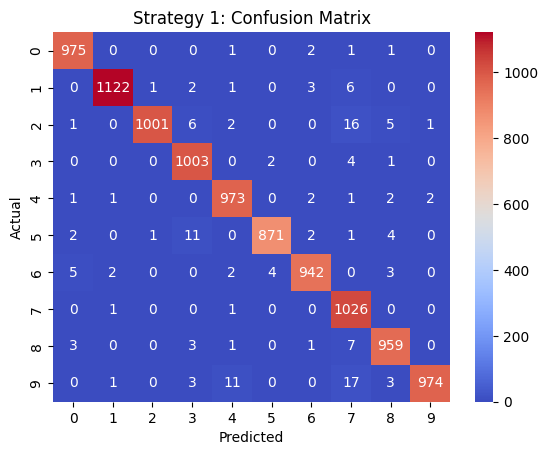

In [7]:
# Cell 7: Transfer Learning Execution & Evaluation for Strategy 1: Linear Evaluation
print("\nStrategy 1: Linear Evaluation")
model_lin, opt_lin = strategy_linear(net)
model_lin = train_transfer(model_lin, opt_lin, 5, loader_mnist_train)
true1, pred1 = evaluate_model(model_lin, loader_mnist_test)
acc1 = np.mean(true1 == pred1)
print(f"[Strategy 1] Test Accuracy: {acc1*100:.2f}%")
print(classification_report(true1, pred1, digits=4))
cm_lin = confusion_matrix(true1, pred1)
sns.heatmap(cm_lin, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.title("Strategy 1: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Strategy 2: Partial Fine-tuning


<ipython-input-6-62a5d645133b>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pretrained_stl10_alternative.pth"))


Transfer Epoch 1: Loss 0.0971, Acc 0.9699
Transfer Epoch 2: Loss 0.0365, Acc 0.9885
Transfer Epoch 3: Loss 0.0278, Acc 0.9913
Transfer Epoch 4: Loss 0.0216, Acc 0.9931
Transfer Epoch 5: Loss 0.0174, Acc 0.9943
[Strategy 2] Test Accuracy: 99.13%
              precision    recall  f1-score   support

           0     0.9929    0.9959    0.9944       980
           1     0.9801    1.0000    0.9900      1135
           2     0.9941    0.9855    0.9898      1032
           3     0.9902    0.9970    0.9936      1010
           4     0.9909    0.9929    0.9919       982
           5     0.9922    0.9933    0.9927       892
           6     0.9948    0.9896    0.9922       958
           7     0.9912    0.9864    0.9888      1028
           8     0.9979    0.9836    0.9907       974
           9     0.9911    0.9881    0.9896      1009

    accuracy                         0.9913     10000
   macro avg     0.9915    0.9912    0.9914     10000
weighted avg     0.9913    0.9913    0.9913     100

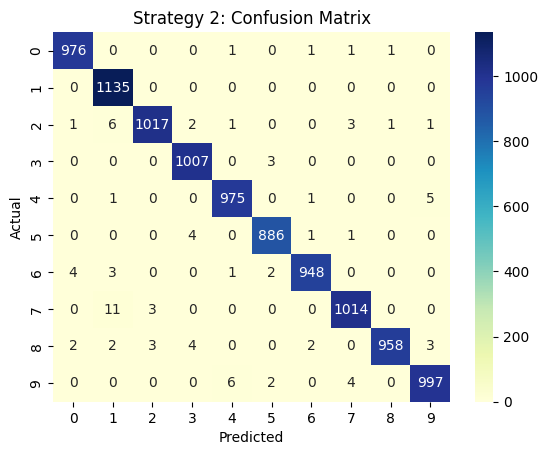

In [8]:
# Cell 8: Transfer Learning Execution & Evaluation for Strategy 2: Partial Fine-tuning
print("\nStrategy 2: Partial Fine-tuning")
model_part, opt_part = strategy_partial(net)
model_part = train_transfer(model_part, opt_part, 5, loader_mnist_train)
true2, pred2 = evaluate_model(model_part, loader_mnist_test)
acc2 = np.mean(true2 == pred2)
print(f"[Strategy 2] Test Accuracy: {acc2*100:.2f}%")
print(classification_report(true2, pred2, digits=4))
cm_part = confusion_matrix(true2, pred2)
sns.heatmap(cm_part, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.title("Strategy 2: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Strategy 3: Full Fine-tuning


<ipython-input-6-62a5d645133b>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pretrained_stl10_alternative.pth"))


Transfer Epoch 1: Loss 0.1616, Acc 0.9542
Transfer Epoch 2: Loss 0.0482, Acc 0.9852
Transfer Epoch 3: Loss 0.0354, Acc 0.9889
Transfer Epoch 4: Loss 0.0278, Acc 0.9912
Transfer Epoch 5: Loss 0.0236, Acc 0.9927
[Strategy 3] Test Accuracy: 99.07%
              precision    recall  f1-score   support

           0     0.9879    0.9959    0.9919       980
           1     0.9904    1.0000    0.9952      1135
           2     0.9990    0.9864    0.9927      1032
           3     0.9872    0.9950    0.9911      1010
           4     0.9869    0.9990    0.9929       982
           5     0.9921    0.9877    0.9899       892
           6     0.9947    0.9864    0.9906       958
           7     0.9827    0.9951    0.9889      1028
           8     0.9877    0.9908    0.9892       974
           9     0.9990    0.9693    0.9839      1009

    accuracy                         0.9907     10000
   macro avg     0.9908    0.9906    0.9906     10000
weighted avg     0.9908    0.9907    0.9907     100

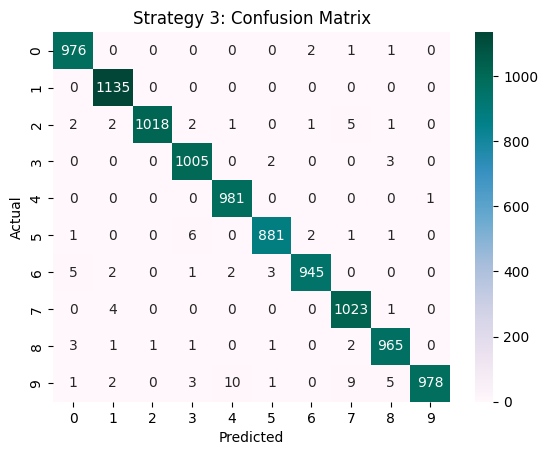

In [9]:
# Cell 9: Transfer Learning Execution & Evaluation for Strategy 3: Full Fine-tuning
print("\nStrategy 3: Full Fine-tuning")
model_full, opt_full = strategy_full(net)
model_full = train_transfer(model_full, opt_full, 5, loader_mnist_train)
true3, pred3 = evaluate_model(model_full, loader_mnist_test)
acc3 = np.mean(true3 == pred3)
print(f"[Strategy 3] Test Accuracy: {acc3*100:.2f}%")
print(classification_report(true3, pred3, digits=4))
cm_full = confusion_matrix(true3, pred3)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.title("Strategy 3: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()